In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [3]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
meta.head(2)
#data = pd.read_csv('../Data/16S/MZJ_dada2_table_ASV.tsv', sep='\t', index_col=0, skiprows=1)
data = pd.read_csv('../Data/16S/DADA2_table/MZJ_dada2_table_L6.tsv', sep='\t', index_col=0, skiprows=1)
data.columns = [i if i!='11_10' else 'C11_10' for i in data.columns]
data = data/data.sum()*100
data.shape
data.head(2)

,SampleID,SampleID_1,Child_ID,Sample_type,Day,Time,MotherID,WMS,Gender,Mode of delivery,...,Day of the last sample,Number of samples,Day of introducing solid food,Day of breastfeeding cessation,Solid food,Breastfeeding,"Feeding mode(BFD:0,MFD:1)","Sibling(Y:1,N:0)","PAE(Y:1,N:0)","Allergy(Y:1,N:0)"
ID,,,,,,,,,,,,,,,,,,,,,
C11_10,11_10,D_10,11,C,25.0,T10,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0
C11_11,11_11,D_11,11,C,29.0,T11,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0


(511, 466)

,C11_10,C1_11,C1_12,C1_13,C1_14,C1_15,C1_16,C1_2,C1_21,C1_22,...,M21_M,M25_M,M26_M,M28_M,M29_M,M31_M,M32_M,M34_M,M35_M,M4_M
#OTU ID,,,,,,,,,,,,,,,,,,,,,
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;__,56.98405,2.594538,4.379425,8.016394,1.582945,0.952849,11.171471,76.198826,33.582792,4.580439,...,0.0,0.0,0.0,0.0,0.0,0.09254,40.57089,0.175747,0.820136,0.660352
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;__,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000


In [10]:
genus = [i for i in data.index if i[-1]!='_']
len(genus)

270

In [11]:
enterotype_m = pd.read_csv('../Results_0609/5.3. 肠型_Mom_pca.tsv', sep='\t', index_col=0)
enterotype_m.head(1)
enterotype_c = pd.read_csv('../Results_0609/5.3. 肠型_Child_pca.tsv', sep='\t', index_col=0)
enterotype_c.head(1)

,CS1,CS2,Cluster
M11_M,2.769759,2.840697,1


,CS1,CS2,Cluster
C11_10,-0.644567,0.613098,1


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

In [80]:
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
result = []
for ti in range(len(Times)):
    target_time = Times[ti]
    target_samples = list(meta.loc[meta['Time']==target_time, :].index)
    #target_time, target_samples
    for tj in range(ti+1):
        source_time = Times[tj]
        source_samples = list(meta.loc[meta['Time']==source_time, :].index)
        #source_time, source_samples
        if target_time=='M' and source_time=='M':
            map_samples = [(i, i) for i in target_samples]
        elif target_time!='M' and source_time=='M':
            map_samples = [('M'+(i.split('_')[0][1:] if 'C13' not in i else '13')+'_M', i) for i in target_samples if 'M'+(i.split('_')[0][1:] if 'C13' not in i else '13')+'_M' in source_samples] 
        else:
            #source_samples, target_samples
            map_samples = [(i.split('_')[0]+'_'+str(source_time)[1:], i) for i in target_samples if i.split('_')[0]+'_'+str(source_time)[1:] in source_samples]
        #'Map:', source_time, target_time, map_samples
        X = data.loc[genus, [i[0] for i in map_samples]].T.values
        y = list(enterotype_m.loc[[i[1] for i in map_samples], 'Cluster']) if target_time=='M' else list(enterotype_c.loc[[i[1] for i in map_samples], 'Cluster'])
        #X.shape, len(y), y
        
        ### Modeling
        if len(y)<2:
            continue
        loo = LeaveOneOut()
        clf = RandomForestClassifier(n_estimators=101, max_features=0.5, max_depth=2, random_state=42)
        scores = []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
            _ = clf.fit(X_train, y_train)
            scores.append(clf.score(X_test, y_test))
        score = np.array(scores).mean()
        source_time, target_time, score
        result.append([source_time, target_time, len(map_samples), score])
result = pd.DataFrame(result, columns=['Source', 'Target', 'N', 'Score'])

('M', 'M', 0.375)

('M', 'T1', 1.0)

('T1', 'T1', 1.0)

('M', 'T2', 0.18181818181818182)

('T1', 'T2', 1.0)

('T2', 'T2', 0.7857142857142857)

('M', 'T3', 0.3333333333333333)

('T1', 'T3', 1.0)

('T2', 'T3', 0.4)

('T3', 'T3', 0.8666666666666667)

('M', 'T4', 0.5)

('T1', 'T4', 1.0)

('T2', 'T4', 0.5384615384615384)

('T3', 'T4', 0.8)

('T4', 'T4', 0.8)

('M', 'T5', 0.625)

('T1', 'T5', 1.0)

('T2', 'T5', 0.23076923076923078)

('T3', 'T5', 0.8571428571428571)

('T4', 'T5', 0.7894736842105263)

('T5', 'T5', 0.85)

('M', 'T6', 0.0)

('T1', 'T6', 0.0)

('T2', 'T6', 0.21428571428571427)

('T3', 'T6', 0.6428571428571429)

('T4', 'T6', 0.6111111111111112)

('T5', 'T6', 0.6111111111111112)

('T6', 'T6', 0.8947368421052632)

('M', 'T7', 0.3333333333333333)

('T1', 'T7', 0.0)

('T2', 'T7', 0.21428571428571427)

('T3', 'T7', 0.5384615384615384)

('T4', 'T7', 0.47058823529411764)

('T5', 'T7', 0.5294117647058824)

('T6', 'T7', 0.6111111111111112)

('T7', 'T7', 0.8333333333333334)

('M', 'T8', 0.3125)

('T1', 'T8', 0.0)

('T2', 'T8', 0.21428571428571427)

('T3', 'T8', 0.6428571428571429)

('T4', 'T8', 0.7222222222222222)

('T5', 'T8', 0.5)

('T6', 'T8', 0.631578947368421)

('T7', 'T8', 0.6666666666666666)

('T8', 'T8', 0.8947368421052632)

('M', 'T9', 0.42857142857142855)

('T2', 'T9', 0.25)

('T3', 'T9', 0.75)

('T4', 'T9', 0.875)

('T5', 'T9', 0.7647058823529411)

('T6', 'T9', 0.8823529411764706)

('T7', 'T9', 0.6875)

('T8', 'T9', 0.9411764705882353)

('T9', 'T9', 0.9411764705882353)

('M', 'T10', 0.18181818181818182)

('T2', 'T10', 0.1111111111111111)

('T3', 'T10', 0.2)

('T4', 'T10', 0.5714285714285714)

('T5', 'T10', 0.5714285714285714)

('T6', 'T10', 0.21428571428571427)

('T7', 'T10', 0.3076923076923077)

('T8', 'T10', 0.5)

('T9', 'T10', 0.7142857142857143)

('T10', 'T10', 0.8571428571428571)

('M', 'T11', 0.7272727272727273)

('T2', 'T11', 0.4)

('T3', 'T11', 0.2222222222222222)

('T4', 'T11', 0.6923076923076923)

('T5', 'T11', 0.6666666666666666)

('T6', 'T11', 0.5384615384615384)

('T7', 'T11', 0.46153846153846156)

('T8', 'T11', 0.7692307692307693)

('T9', 'T11', 0.5833333333333334)

('T10', 'T11', 0.36363636363636365)

('T11', 'T11', 0.7692307692307693)

('M', 'T12', 0.4)

('T2', 'T12', 0.4)

('T3', 'T12', 0.18181818181818182)

('T4', 'T12', 0.4)

('T5', 'T12', 0.6)

('T6', 'T12', 0.4)

('T7', 'T12', 0.14285714285714285)

('T8', 'T12', 0.4)

('T9', 'T12', 0.42857142857142855)

('T10', 'T12', 0.5)

('T11', 'T12', 0.2727272727272727)

('T12', 'T12', 0.9375)

('M', 'T13', 0.5)

('T2', 'T13', 0.4)

('T3', 'T13', 0.5)

('T4', 'T13', 0.5333333333333333)

('T5', 'T13', 0.4666666666666667)

('T6', 'T13', 0.4)

('T7', 'T13', 0.2857142857142857)

('T8', 'T13', 0.4)

('T9', 'T13', 0.42857142857142855)

('T10', 'T13', 0.5)

('T11', 'T13', 0.45454545454545453)

('T12', 'T13', 0.6)

('T13', 'T13', 0.6875)

('M', 'T14', 0.35714285714285715)

('T2', 'T14', 0.5454545454545454)

('T3', 'T14', 0.09090909090909091)

('T4', 'T14', 0.3125)

('T5', 'T14', 0.625)

('T6', 'T14', 0.5625)

('T7', 'T14', 0.5333333333333333)

('T8', 'T14', 0.375)

('T9', 'T14', 0.5333333333333333)

('T10', 'T14', 0.5384615384615384)

('T11', 'T14', 0.4166666666666667)

('T12', 'T14', 0.6666666666666666)

('T13', 'T14', 0.75)

('T14', 'T14', 0.8823529411764706)

('M', 'T15', 0.5384615384615384)

('T2', 'T15', 0.4)

('T3', 'T15', 0.09090909090909091)

('T4', 'T15', 0.6)

('T5', 'T15', 0.6666666666666666)

('T6', 'T15', 0.6)

('T7', 'T15', 0.5)

('T8', 'T15', 0.6666666666666666)

('T9', 'T15', 0.5714285714285714)

('T10', 'T15', 0.7272727272727273)

('T11', 'T15', 0.7)

('T12', 'T15', 0.8461538461538461)

('T13', 'T15', 0.7857142857142857)

('T14', 'T15', 0.8)

('T15', 'T15', 0.75)

('M', 'T16', 0.5)

('T2', 'T16', 0.5454545454545454)

('T3', 'T16', 0.36363636363636365)

('T4', 'T16', 0.625)

('T5', 'T16', 0.625)

('T6', 'T16', 0.625)

('T7', 'T16', 0.4666666666666667)

('T8', 'T16', 0.5)

('T9', 'T16', 0.6666666666666666)

('T10', 'T16', 0.5833333333333334)

('T11', 'T16', 0.6363636363636364)

('T12', 'T16', 0.6428571428571429)

('T13', 'T16', 0.8)

('T14', 'T16', 0.75)

('T15', 'T16', 0.75)

('T16', 'T16', 0.7647058823529411)

('M', 'T17', 0.6666666666666666)

('T1', 'T17', 1.0)

('T2', 'T17', 0.6666666666666666)

('T3', 'T17', 0.7272727272727273)

('T4', 'T17', 0.5625)

('T5', 'T17', 0.5625)

('T6', 'T17', 0.6875)

('T7', 'T17', 0.6)

('T8', 'T17', 0.625)

('T9', 'T17', 0.8571428571428571)

('T10', 'T17', 0.5833333333333334)

('T11', 'T17', 0.6)

('T12', 'T17', 0.6923076923076923)

('T13', 'T17', 0.7692307692307693)

('T14', 'T17', 0.7142857142857143)

('T15', 'T17', 0.5714285714285714)

('T16', 'T17', 0.7333333333333333)

('T17', 'T17', 0.8823529411764706)

('M', 'T18', 0.5)

('T2', 'T18', 0.7777777777777778)

('T3', 'T18', 0.42857142857142855)

('T4', 'T18', 0.5454545454545454)

('T5', 'T18', 0.45454545454545453)

('T6', 'T18', 0.36363636363636365)

('T7', 'T18', 0.36363636363636365)

('T8', 'T18', 0.5454545454545454)

('T9', 'T18', 0.8888888888888888)

('T10', 'T18', 0.625)

('T11', 'T18', 0.7142857142857143)

('T12', 'T18', 0.6666666666666666)

('T13', 'T18', 0.7)

('T14', 'T18', 0.8181818181818182)

('T15', 'T18', 0.7)

('T16', 'T18', 0.9090909090909091)

('T17', 'T18', 0.8333333333333334)

('T18', 'T18', 0.75)

('M', 'T19', 0.5)

('T1', 'T19', 1.0)

('T2', 'T19', 0.5833333333333334)

('T3', 'T19', 0.1)

('T4', 'T19', 0.42857142857142855)

('T5', 'T19', 0.7857142857142857)

('T6', 'T19', 0.35714285714285715)

('T7', 'T19', 0.3076923076923077)

('T8', 'T19', 0.5714285714285714)

('T9', 'T19', 0.5833333333333334)

('T10', 'T19', 0.6)

('T11', 'T19', 0.4444444444444444)

('T12', 'T19', 0.45454545454545453)

('T13', 'T19', 0.6363636363636364)

('T14', 'T19', 0.75)

('T15', 'T19', 0.7272727272727273)

('T16', 'T19', 0.9166666666666666)

('T17', 'T19', 0.7142857142857143)

('T18', 'T19', 0.6363636363636364)

('T19', 'T19', 0.8)

('M', 'T20', 0.5)

('T1', 'T20', 1.0)

('T2', 'T20', 0.3333333333333333)

('T3', 'T20', 0.125)

('T4', 'T20', 0.5384615384615384)

('T5', 'T20', 0.46153846153846156)

('T6', 'T20', 0.5)

('T7', 'T20', 0.5454545454545454)

('T8', 'T20', 0.5833333333333334)

('T9', 'T20', 0.36363636363636365)

('T10', 'T20', 0.4)

('T11', 'T20', 0.375)

('T12', 'T20', 0.4)

('T13', 'T20', 0.5)

('T14', 'T20', 0.5)

('T15', 'T20', 0.7777777777777778)

('T16', 'T20', 0.7)

('T17', 'T20', 0.6363636363636364)

('T18', 'T20', 0.42857142857142855)

('T19', 'T20', 0.5454545454545454)

('T20', 'T20', 0.6923076923076923)

('M', 'T21', 0.6)

('T1', 'T21', 1.0)

('T2', 'T21', 0.5)

('T3', 'T21', 0.2727272727272727)

('T4', 'T21', 0.375)

('T5', 'T21', 0.5625)

('T6', 'T21', 0.1875)

('T7', 'T21', 0.2)

('T8', 'T21', 0.5)

('T9', 'T21', 0.42857142857142855)

('T10', 'T21', 0.7272727272727273)

('T11', 'T21', 0.6363636363636364)

('T12', 'T21', 0.5384615384615384)

('T13', 'T21', 0.6153846153846154)

('T14', 'T21', 0.7142857142857143)

('T15', 'T21', 0.7142857142857143)

('T16', 'T21', 0.6666666666666666)

('T17', 'T21', 0.6)

('T18', 'T21', 0.5454545454545454)

('T19', 'T21', 0.7142857142857143)

('T20', 'T21', 0.5833333333333334)

('T21', 'T21', 0.8823529411764706)

('M', 'T22', 0.6)

('T1', 'T22', 0.0)

('T2', 'T22', 0.6153846153846154)

('T3', 'T22', 0.16666666666666666)

('T4', 'T22', 0.47058823529411764)

('T5', 'T22', 0.7058823529411765)

('T6', 'T22', 0.5294117647058824)

('T7', 'T22', 0.5)

('T8', 'T22', 0.6470588235294118)

('T9', 'T22', 0.4666666666666667)

('T10', 'T22', 0.75)

('T11', 'T22', 0.9090909090909091)

('T12', 'T22', 0.5714285714285714)

('T13', 'T22', 0.7857142857142857)

('T14', 'T22', 0.7333333333333333)

('T15', 'T22', 0.9285714285714286)

('T16', 'T22', 0.9333333333333333)

('T17', 'T22', 0.6666666666666666)

('T18', 'T22', 0.6363636363636364)

('T19', 'T22', 0.8571428571428571)

('T20', 'T22', 0.6923076923076923)

('T21', 'T22', 0.75)

('T22', 'T22', 0.9444444444444444)

('M', 'T23', 0.8)

('T1', 'T23', 1.0)

('T2', 'T23', 0.6363636363636364)

('T3', 'T23', 0.6923076923076923)

('T4', 'T23', 0.75)

('T5', 'T23', 0.9375)

('T6', 'T23', 0.75)

('T7', 'T23', 0.7333333333333333)

('T8', 'T23', 0.8125)

('T9', 'T23', 0.9285714285714286)

('T10', 'T23', 0.6363636363636364)

('T11', 'T23', 0.8181818181818182)

('T12', 'T23', 0.7142857142857143)

('T13', 'T23', 0.7692307692307693)

('T14', 'T23', 0.7857142857142857)

('T15', 'T23', 0.8571428571428571)

('T16', 'T23', 1.0)

('T17', 'T23', 0.7857142857142857)

('T18', 'T23', 0.7777777777777778)

('T19', 'T23', 0.9166666666666666)

('T20', 'T23', 0.8)

('T21', 'T23', 0.9285714285714286)

('T22', 'T23', 0.8666666666666667)

('T23', 'T23', 0.9411764705882353)

('M', 'T24', 0.5454545454545454)

('T2', 'T24', 0.7)

('T3', 'T24', 0.3333333333333333)

('T4', 'T24', 0.6428571428571429)

('T5', 'T24', 0.6153846153846154)

('T6', 'T24', 0.6153846153846154)

('T7', 'T24', 0.5833333333333334)

('T8', 'T24', 0.5384615384615384)

('T9', 'T24', 0.5454545454545454)

('T10', 'T24', 0.7)

('T11', 'T24', 0.6666666666666666)

('T12', 'T24', 0.7272727272727273)

('T13', 'T24', 0.6666666666666666)

('T14', 'T24', 0.5384615384615384)

('T15', 'T24', 0.5454545454545454)

('T16', 'T24', 0.75)

('T17', 'T24', 0.6666666666666666)

('T18', 'T24', 0.8888888888888888)

('T19', 'T24', 0.8)

('T20', 'T24', 0.6666666666666666)

('T21', 'T24', 0.5454545454545454)

('T22', 'T24', 0.6153846153846154)

('T23', 'T24', 0.7272727272727273)

('T24', 'T24', 0.9285714285714286)

('M', 'T25', 0.5333333333333333)

('T1', 'T25', 1.0)

('T2', 'T25', 0.3333333333333333)

('T3', 'T25', 0.25)

('T4', 'T25', 0.625)

('T5', 'T25', 0.6470588235294118)

('T6', 'T25', 0.3125)

('T7', 'T25', 0.4)

('T8', 'T25', 0.875)

('T9', 'T25', 0.2)

('T10', 'T25', 0.5833333333333334)

('T11', 'T25', 0.9090909090909091)

('T12', 'T25', 0.42857142857142855)

('T13', 'T25', 0.5384615384615384)

('T14', 'T25', 0.5714285714285714)

('T15', 'T25', 0.8461538461538461)

('T16', 'T25', 0.6428571428571429)

('T17', 'T25', 0.42857142857142855)

('T18', 'T25', 0.6666666666666666)

('T19', 'T25', 0.6923076923076923)

('T20', 'T25', 0.5833333333333334)

('T21', 'T25', 0.8)

('T22', 'T25', 0.8666666666666667)

('T23', 'T25', 0.8666666666666667)

('T24', 'T25', 0.7272727272727273)

('T25', 'T25', 0.9411764705882353)

('M', 'T26', 0.375)

('T1', 'T26', 0.0)

('T2', 'T26', 0.3076923076923077)

('T3', 'T26', 0.5384615384615384)

('T4', 'T26', 0.6666666666666666)

('T5', 'T26', 0.3888888888888889)

('T6', 'T26', 0.2222222222222222)

('T7', 'T26', 0.23529411764705882)

('T8', 'T26', 0.4444444444444444)

('T9', 'T26', 0.4375)

('T10', 'T26', 0.38461538461538464)

('T11', 'T26', 0.3333333333333333)

('T12', 'T26', 0.6)

('T13', 'T26', 0.6666666666666666)

('T14', 'T26', 0.8125)

('T15', 'T26', 0.875)

('T16', 'T26', 0.47058823529411764)

('T17', 'T26', 0.23529411764705882)

('T18', 'T26', 0.5)

('T19', 'T26', 0.5)

('T20', 'T26', 0.5)

('T21', 'T26', 0.4117647058823529)

('T22', 'T26', 0.7058823529411765)

('T23', 'T26', 0.75)

('T24', 'T26', 0.6923076923076923)

('T25', 'T26', 0.6875)

('T26', 'T26', 0.9473684210526315)

('M', 'T27', 0.5)

('T1', 'T27', 0.0)

('T2', 'T27', 0.5384615384615384)

('T3', 'T27', 0.6923076923076923)

('T4', 'T27', 0.6666666666666666)

('T5', 'T27', 0.6666666666666666)

('T6', 'T27', 0.5555555555555556)

('T7', 'T27', 0.47058823529411764)

('T8', 'T27', 0.5555555555555556)

('T9', 'T27', 0.625)

('T10', 'T27', 0.6153846153846154)

('T11', 'T27', 0.3333333333333333)

('T12', 'T27', 0.5333333333333333)

('T13', 'T27', 1.0)

('T14', 'T27', 0.6875)

('T15', 'T27', 0.625)

('T16', 'T27', 0.47058823529411764)

('T17', 'T27', 0.6470588235294118)

('T18', 'T27', 0.8333333333333334)

('T19', 'T27', 0.7857142857142857)

('T20', 'T27', 0.6666666666666666)

('T21', 'T27', 0.4117647058823529)

('T22', 'T27', 0.5882352941176471)

('T23', 'T27', 0.9375)

('T24', 'T27', 0.7692307692307693)

('T25', 'T27', 0.625)

('T26', 'T27', 0.8421052631578947)

('T27', 'T27', 0.9473684210526315)

In [96]:
result.to_csv('../Results_0609/5.4. 肠型预测_f0.5d2.csv')

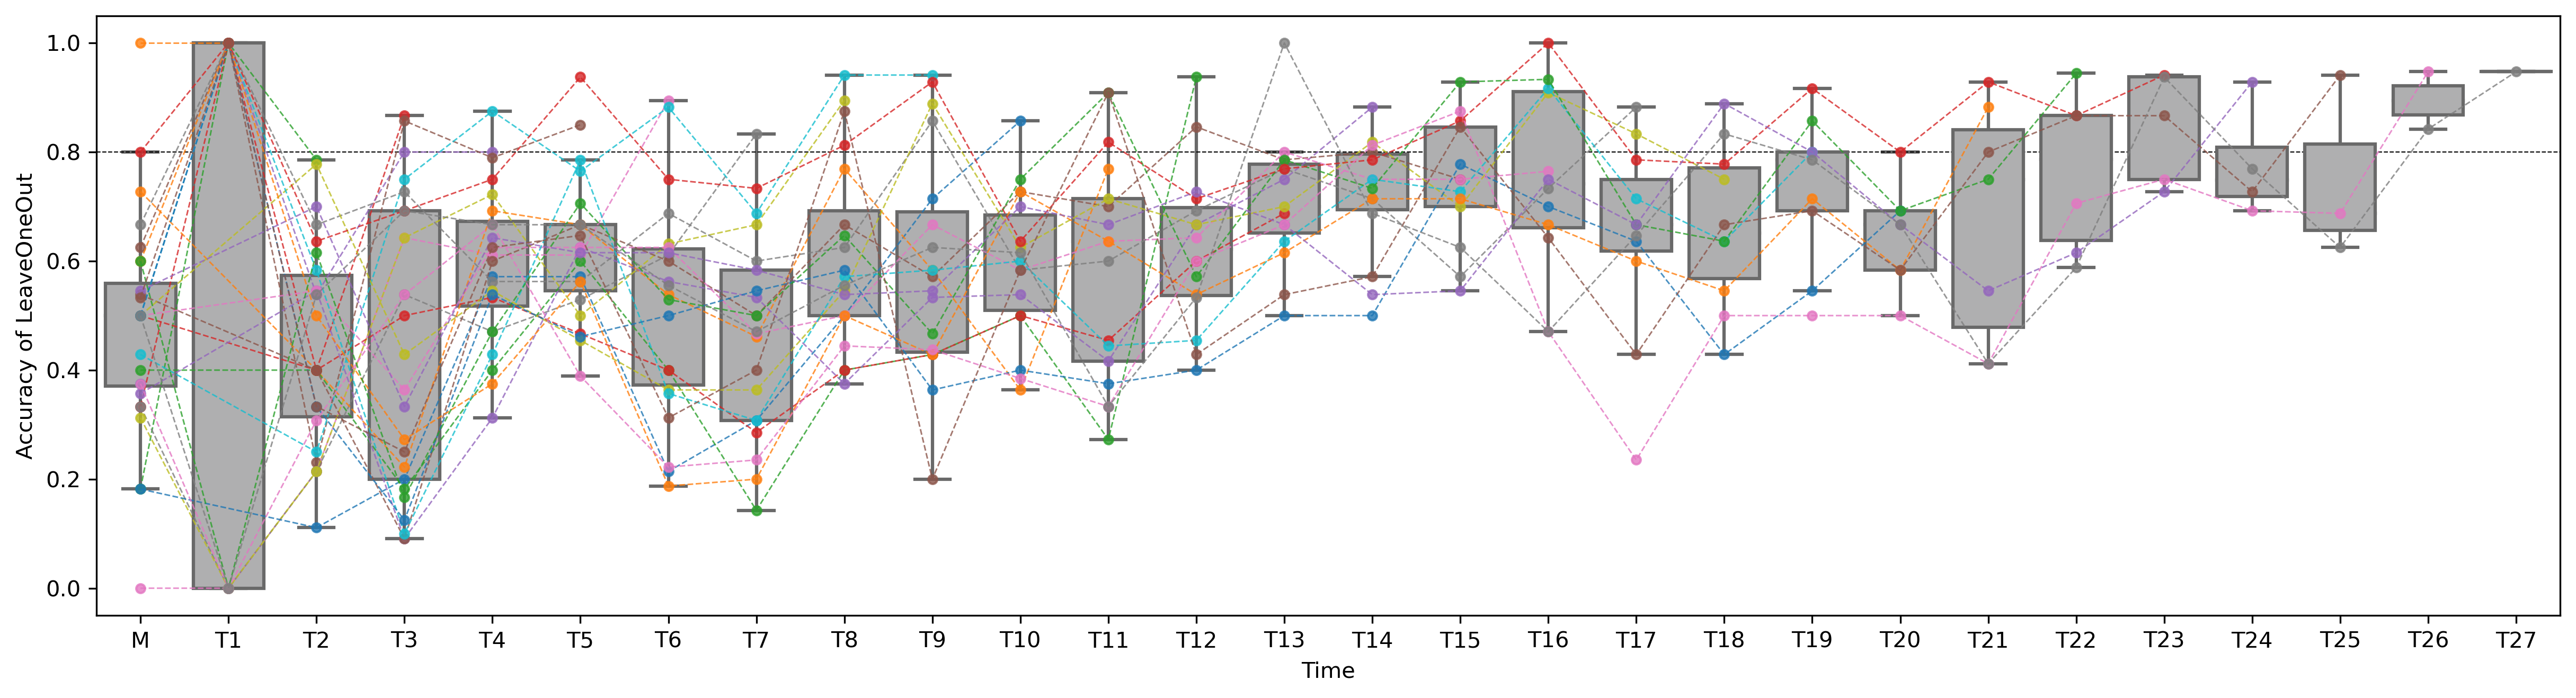

In [97]:
fig = plt.figure(figsize=(20, 5), dpi=300)
_ = sns.boxplot(x="Source", y="Score", data=result, zorder=-1, color='#afafb0', fliersize=0)
for t in Times:
    temp = result.loc[result['Target']==t, :]
    _ = plt.plot([int(i[1:]) if i!='M' else 0 for i in temp['Source']], temp['Score'], 
                 marker='o',ls='--', lw=0.7, alpha=0.8, ms=4, zorder=9)
_ = plt.hlines(y=0.8, xmin=-0.5, xmax=27.5, ls='--', lw=0.5, color='k', zorder=-1)
_ = plt.xticks(range(28), Times)
_ = plt.xlabel('Time')
_ = plt.ylabel('Accuracy of LeaveOneOut')
fig.savefig('../Results_0609/5.4. 肠型预测_f0.5d2.pdf', dpi=300)

In [9]:
result = pd.read_csv('../Results_0609/5.4. 肠型预测_f0.5d2.csv', index_col=0)
result.loc[(result['Source']=='M')&(result['Target']!='M'), :].mean()

N        13.481481
Score     0.482952
dtype: float64